In [1]:
!wget https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0

--2022-12-11 19:09:23--  https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nilt43hyl1dx82k/dataset.zip [following]
--2022-12-11 19:09:24--  https://www.dropbox.com/s/raw/nilt43hyl1dx82k/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18b28df657708ff484b827fcab.dl.dropboxusercontent.com/cd/0/inline/ByfZeZC1YGz_FrQ3e7EbADituoNyTnbT3JImtGfRpaEUrH2lBe0Ovap_77KKJSv6H_OAF-mE_XPNra_-gGdOod6NIwY1p39LZHgyIHIWwyrc-jikQPR2e0NU8nCNAiXFrKU42GYaonVRjGSppI1e4ArUbw_Z-pRSqsnMXxlwcr7eWw/file# [following]
--2022-12-11 19:09:24--  https://uc18b28df657708ff484b827fcab.dl.dropboxusercontent.com/cd/0/inline/ByfZeZC1YGz_FrQ3e7EbADituoNyTnbT3JImtGfRpaEUrH2lBe0Ovap_77KKJSv6H_OAF-mE_XPNra

In [2]:
!unzip dataset.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
import tensorflow as tf
import cv2

from keras import layers
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator 
from keras.losses import categorical_crossentropy
from keras.utils import  img_to_array, load_img

import numpy as np
import matplotlib.pyplot as plt

import os 

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"             # just to slove an error relating the conda packages

In [4]:
# parameters
image_size=(48,48)
batch_size = 64
num_epochs = 110
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'

In [5]:
model = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = input_shape),
    layers.RandomZoom(0.2, 0.3),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    layers.Dropout(0.25),
                  
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(7, activation='softmax'),
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0

In [7]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy'])

In [11]:
# Training data + data augmentation
train_datagen = ImageDataGenerator(
     rotation_range=10,
     width_shift_range=0.1,
     height_shift_range=0.1,
     zoom_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "train",
                                               target_size=image_size,
                                               color_mode= "grayscale",
                                               batch_size=batch_size,
                                               shuffle=True
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [12]:
train_data.image_shape

(48, 48, 1)

In [13]:
# Validation data
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "test",
                                           target_size=image_size,
                                           color_mode= "grayscale",
                                           batch_size=batch_size,
                                           shuffle=False
                                  )
# val_data.class_indices                                 

Found 7178 images belonging to 7 classes.


In [14]:
data =list( train_data.classes)
for i, e in enumerate(data):
  if e == 0:
    data[i] = 'angry'
  elif e == 1:
    data[i] = 'disgust'
  elif e == 2:
    data[i] = 'fear'
  elif e == 3:
    data[i] = 'happy'
  elif e == 4:
    data[i] = 'neutral'
  elif e == 5:
    data[i] = 'sad'
  elif e == 6:
    data[i] = 'surprise'

# unique, counts = np.unique(data, return_counts=True)
# dic = dict(zip(unique, counts))


(0.0, 7520.0)

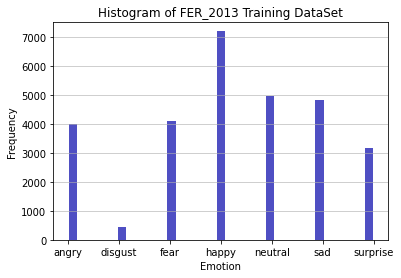

In [15]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=data, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, label=train_data.class_indices.keys())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Histogram of FER_2013 Training DataSet')

# Set a clean upper y-axis limit.
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 + 300 if maxfreq % 10 else maxfreq + 10)

In [16]:
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
# trained_models_path = base_path + '_from_scratch_'
# model_names = trained_models_path + f'.{epoch:02d}-{val_acc:.2f}.hdf5'
# model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [csv_logger, early_stop]
# callbacks = [model_checkpoint, csv_logger, early_stop]

In [19]:

hist = model.fit(train_data, 
                          #  steps_per_epoch= 10, 
                           epochs= num_epochs, 
                           validation_data= val_data, 
                           callbacks=callbacks
                           )

Epoch 1/110
449/449 [==============================] - 50s 111ms/step - loss: 1.6204 - accuracy: 0.3615 - val_loss: 1.5650 - val_accuracy: 0.3865
Epoch 2/110
449/449 [==============================] - 45s 101ms/step - loss: 1.5433 - accuracy: 0.3989 - val_loss: 1.4995 - val_accuracy: 0.4327
Epoch 3/110
449/449 [==============================] - 46s 103ms/step - loss: 1.4877 - accuracy: 0.4192 - val_loss: 1.3478 - val_accuracy: 0.4766
Epoch 4/110
449/449 [==============================] - 46s 102ms/step - loss: 1.4374 - accuracy: 0.4429 - val_loss: 1.2960 - val_accuracy: 0.5042
Epoch 5/110
449/449 [==============================] - 46s 103ms/step - loss: 1.4039 - accuracy: 0.4561 - val_loss: 1.3182 - val_accuracy: 0.4922
Epoch 6/110
449/449 [==============================] - 53s 118ms/step - loss: 1.3847 - accuracy: 0.4663 - val_loss: 1.2604 - val_accuracy: 0.5109
Epoch 7/110
449/449 [==============================] - 46s 102ms/step - loss: 1.3531 - accuracy: 0.4806 - val_loss: 1.2869 -

In [20]:
model.save('models/long_augmented_model.h5')

<ipython-input-23-6971cbbde55a>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_data)


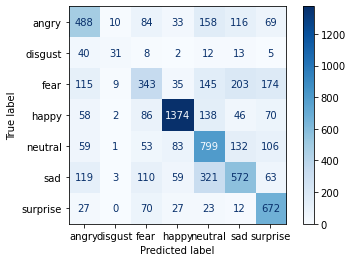

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model = tf.keras.models.load_model('models/long_augmented_model.h5')

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)

y_test = val_data.classes

labels = val_data.class_indices.keys()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

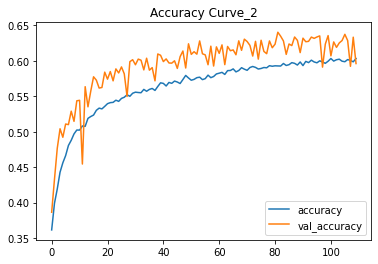

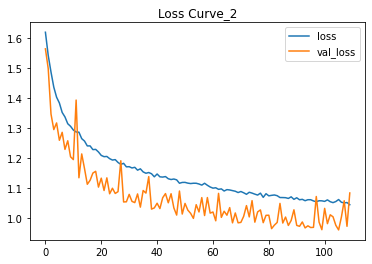

In [22]:
import pandas as pd 
history_frame_2 = pd.DataFrame(hist.history)
history_frame_2.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.title("Accuracy Curve_2")
history_frame_2.loc[:, ["loss", "val_loss"]].plot()
plt.title("Loss Curve_2")
plt.show()